# Verify that the baseline curves can fit the fresh data.

04/30/2023

Andrew Weng

In [1]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

from src import cellsim as cellsim 

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from src import plotter as plotter
from src import dvdq as dvdq
from src import modelutils as mu 

%load_ext autoreload

# Load the Experimental Data

In [2]:
plotter.initialize(plt)
target_dir = os.getcwd()
target_dir_arbin = f'{target_dir}/data/raw/from-voltaiq'
file_indices_to_include = np.array([1])

cellid = 152064

if cellid == 152064:
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                    ]

    daq_channel = 'Key_CH1'

    hr_max = 65

elif cellid == 152074: # BASELINE FORMATION (repeat 2)
    
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
                    ]

    daq_channel = 'Key_CH0'

    hr_max = 65

# Load the Arbin Data
df_arbin_list = []

for file in np.array(file_arbin_list)[file_indices_to_include]:

    df = pd.read_csv(file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp']= df['Timestamp'].apply(lambda x : x.tz_localize(None))
    df_arbin_list.append(df)

df_arbin = pd.concat(df_arbin_list, axis=0)

df_arbin = df_arbin[df_arbin['Cycle Number'] == 39]
df_arbin = df_arbin[df_arbin['Step Index'] == 24]

# Filter the Arbin Data
ii = df_arbin['Current (A)']
qq = df_arbin['Charge Capacity (Ah)']
tv = df_arbin['Timestamp'].astype(int)
tt = (tv - np.min(tv)) / 1e9
vv = df_arbin['Potential (V)']

size_factor = 65
window_length = int(len(tt) / size_factor)
window_length = window_length + 1 if window_length % 2 == 0 else window_length
polyorder = 2

# SG filter on the data to make it smooth
dq1 = savgol_filter(qq, window_length, polyorder, 1)
dv1 = savgol_filter(vv, window_length, polyorder, 1)

out = dict()
out['chg_capacity'] = qq 
out['chg_voltage'] = vv
out['chg_dvdq'] = dv1/dq1
df_out = pd.DataFrame(out)
df_out.to_csv(f'diagnostic_test_cell_umbl2022feb_cell{cellid}.csv')

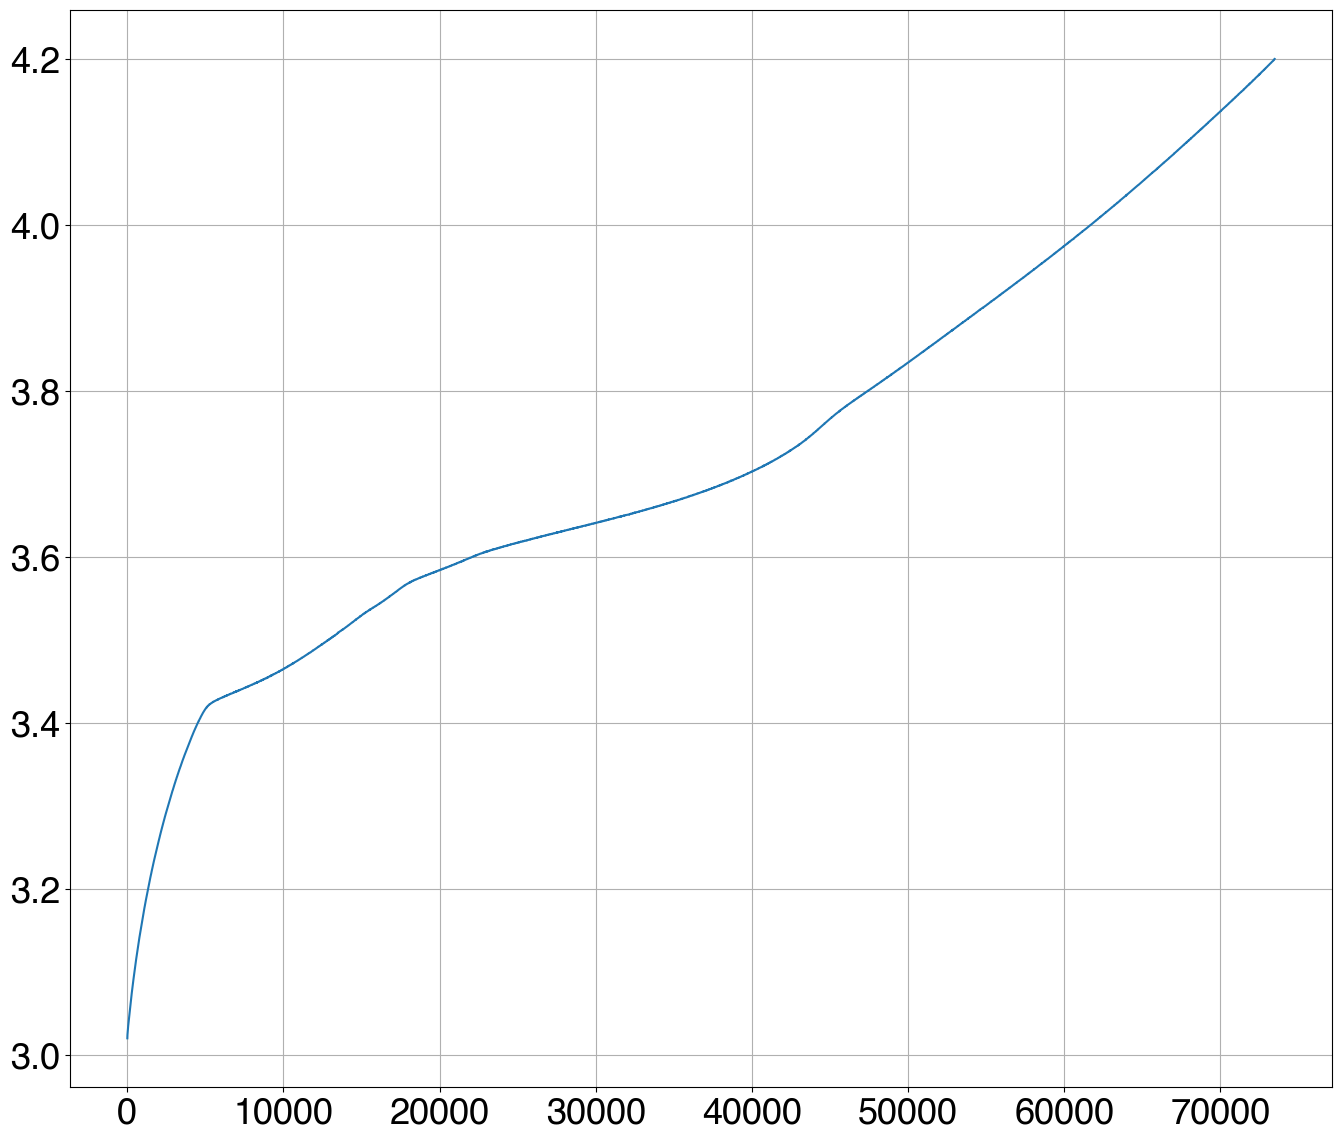

In [3]:
plt.figure()
plt.plot(tt, vv)

/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


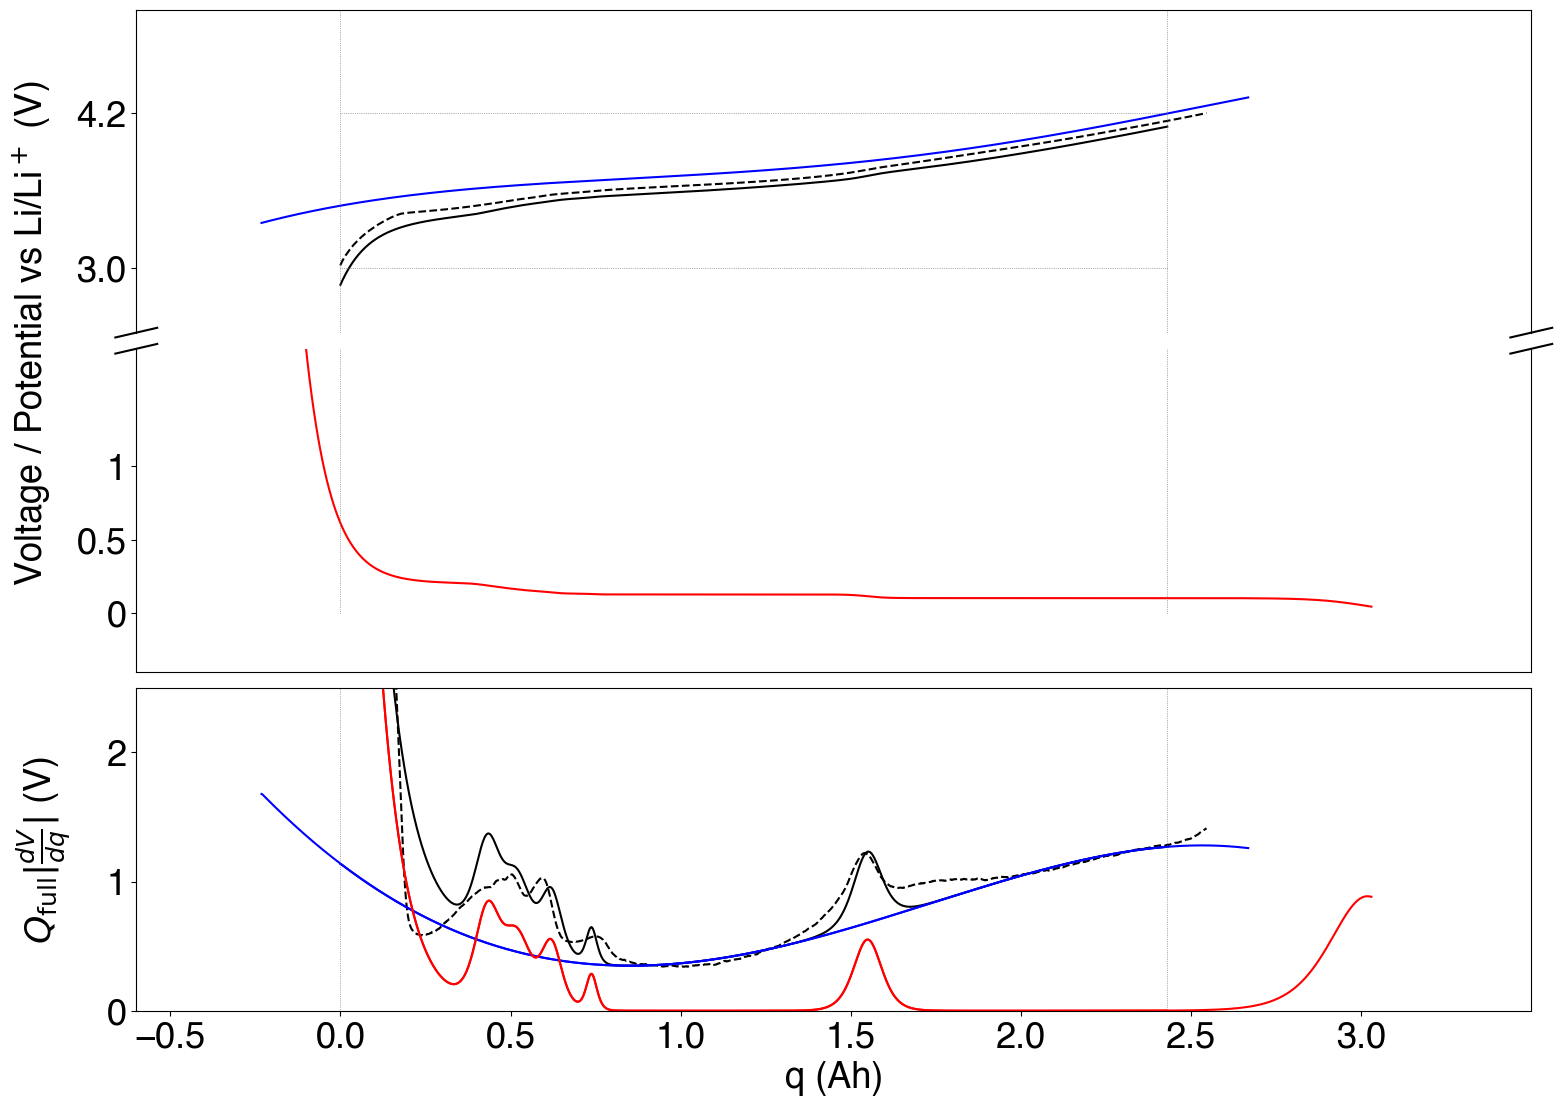

In [12]:
Cp = 2.9 # Ah
Cn = 3.14
# x100 = 0.90
# y100 = 0.03
x0 = 0.035
y0 = 0.92

qmax = 2.43 # Ah

# x0 = x100 - qmax/Cn
# y0 = y100 + qmax/Cp

x100 = x0 + qmax/Cn
y100 = y0 - qmax/Cp

y_vec = np.linspace(0, 1, 1000)
x_vec = np.linspace(0, 1, 1000)

qpos = Cp*(y0 - y_vec)
vpos = mu.UpNMC(y_vec)
qneg = Cn*(x_vec - x0)
vneg = mu.UnGr(x_vec)

# Full cell capacity
q = np.linspace(0, qmax, 1000)

y = y0 - q/Cp
x = x0 + q/Cn
Voc = mu.UpNMC(y) - mu.UnGr(x) 
Up = mu.UpNMC(y)
Un = mu.UnGr(x) 

plotter.initialize(plt)

gridspec = dict(hspace=0.05, height_ratios=[1, 1, 1])

fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, 
                                gridspec_kw=gridspec, 
                                figsize=(18, 13))

# Make the cathode and full cell voltage plot
ax1.plot(qq, vv, c='k', ls='--')
ax1.plot(q, Voc, 'k')
ax1.plot(qpos, vpos, 'b')
ax1.set_ylim((2.5, 5))
ax1.set_ylabel('Voltage / Potential vs Li/Li$^+$ (V)')
ax1.set_yticks([3, 4.2])
ax1.hlines([3.0, 4.2], np.min(q), np.max(q), 
            color=(0.4, 0.4, 0.4), linewidth=0.5, linestyle=':')
ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.yaxis.set_label_coords(-0.06, 0.00)
ax1.spines['bottom'].set_visible(False)

# Make the anode voltage plot
ax2.spines['top'].set_visible(False)
ax2.plot(qneg, vneg, 'r')
ax2.set_ylim((-0.4, 1.8))
ax2.set_yticks([0, 0.50, 1])
ax2.set_yticklabels([0, 0.50, 1])
ax2.set_xticklabels([])
ax2.set_xticks([])

# Make the split lines
d = 0.015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d,+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(-d,+d), **kwargs)

kwargs.update(transform=ax2.transAxes, color='k', clip_on=False) 
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((1-d,1+d), (1-d,1+d), **kwargs)

# Make the dV/dQ plot
ax3.plot(qq, dv1/dq1*np.max(qq), c='k', ls='--')
ax3.plot(q, np.gradient(Voc)/np.gradient(q)*np.max(q), 'k')
ax3.plot(q, np.gradient(Up)/np.gradient(q)*np.max(q), 'b')
ax3.plot(qpos, np.gradient(vpos)/np.gradient(qpos)*np.max(q), 'b')
ax3.plot(q, -np.gradient(Un)/np.gradient(q)*np.max(q), 'r')
ax3.plot(qneg, -np.gradient(vneg)/np.gradient(qneg)*np.max(q), 'r')
ax3.yaxis.set_label_coords(-0.045, 0.00)
ax3.set_xlabel('q (Ah)')
ax3.set_xticks([-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3])
ax3.set_ylabel(r'$Q_{\mathrm{full}}\left|\frac{dV}{dq}\right|$ (V)')
ax3.set_ylim((0, 2.5))

# Set shared axis settings
for ax in [ax1, ax2, ax3]:
    ax.set_xlim((-0.6, 3.5))
    ax.grid(False)
    ax.vlines(x=[0, np.max(q)], ymin=0, ymax=5, 
              color=[0.4, 0.4, 0.4], linewidth=0.5,
              linestyle=':')

(3.0, 4.2)

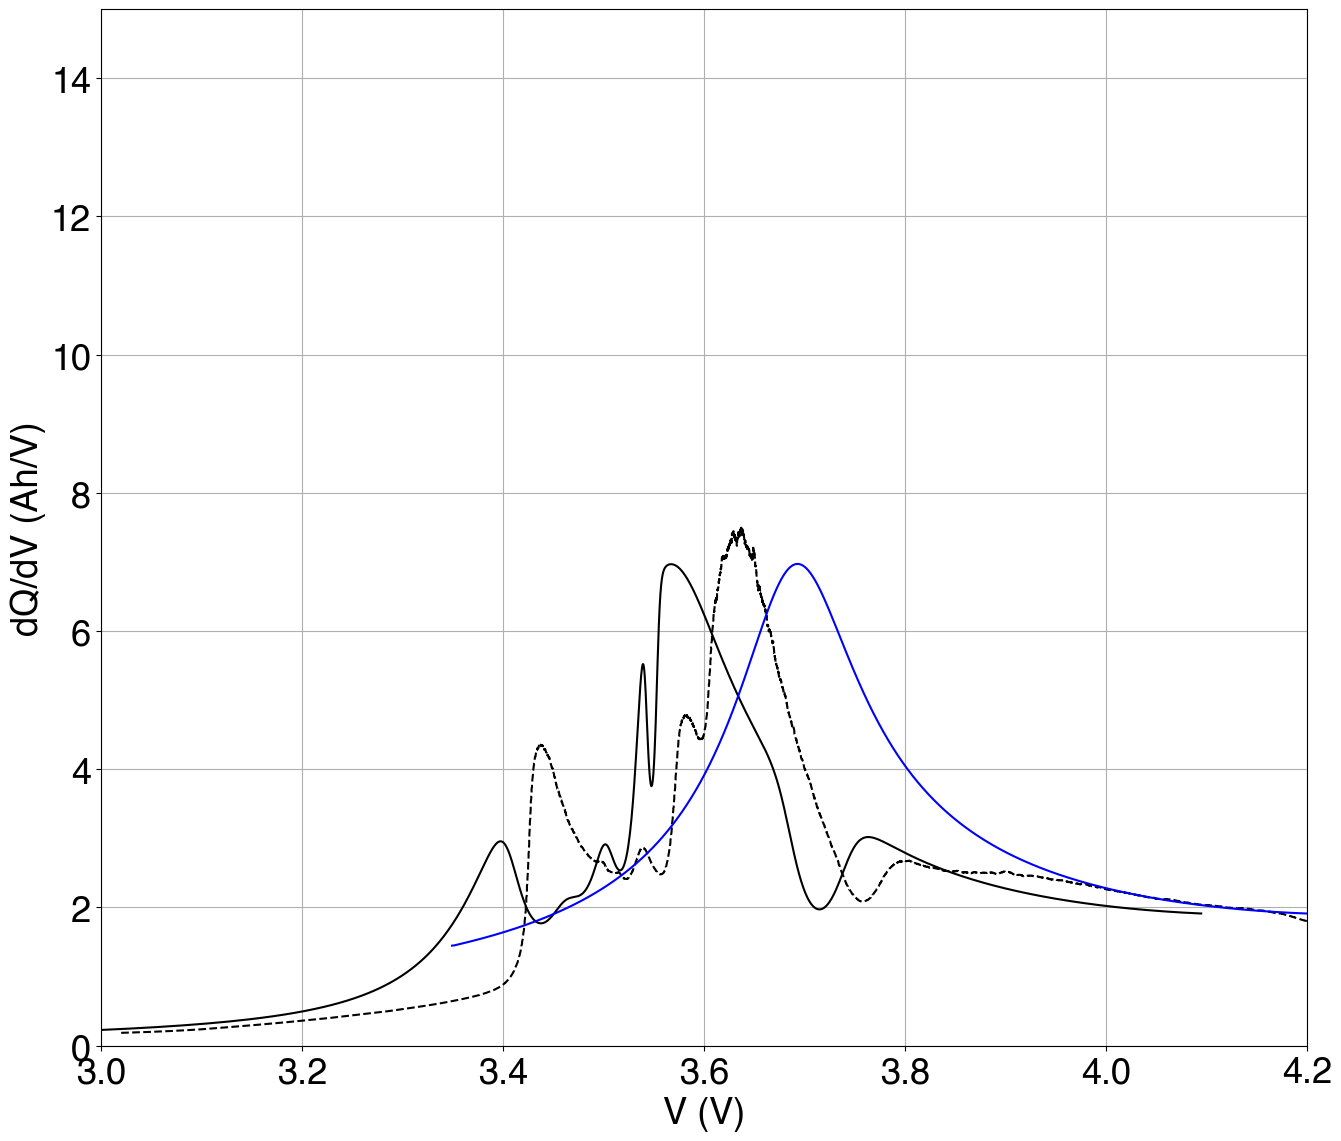

In [14]:
plt.figure()

plt.plot(vv, dq1/dv1, c='k', ls='--')
plt.plot(Voc, np.gradient(q)/np.gradient(Voc), 'k')
plt.plot(vpos, np.gradient(qpos)/np.gradient(vpos), 'b')
plt.plot(vneg, np.gradient(qneg)/np.gradient(vneg), 'r')
plt.xlabel('V (V)')
plt.ylabel('dQ/dV (Ah/V)')
plt.ylim((0, 15))
plt.xlim((3, 4.2))